<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 5px; height: 50px"> 

#   Project 4: Detecting Hate Speech

> SG-DSI-41 Group 01: Lionel Foo, Joel Lim, Poon Wenzhe, Daryl Chia

---


#### <b> Notebook: 02B-M2 Classification Model (Binary Classification - RNN with GloVe Word Embeddings) </b>

<b>(a) Recap: Key Insights & Steps Going Forward from "Notebook 02A-M2 Classification Model (Multiclass Classification - RNN with GloVe Word Embeddings"</b>

* Use of a GloVe-based word vectoriser improves model performance - in line with the fact that it helps account for semantic differences across texts.
* It is challenging to separably identify "hate speech", considering that it comprises the original/"test" dataset's minority class 
* Going forward:
    * Continue to use a GloVe-based word vectoriser
    * Collapse "hate speech" and "offensive language" categories, as a "hurtful comments" category

<br>

<b>(b) Notebook Objectives</b>

This notebook thus continues the modeling process based on the insights above, namely by: 
* Continuing use of a GloVe-based word vectoriser
* Performing binary classification (collapsing "hate speech" and "offensive language" categories, as a "hurtful comments" category)

<b>(c) Notebook Outline</b>

1. Import Libraries, Data & Specify Random Seeds
2. Prepare Data for Modelling
3. Construct GloVe Word Embedding Matrix
4. Train Classification Model
5. Evaluate Classification Model
6. Export Fitted Model's Components as Pickle Files

<br>

---

<b> 1. Import Libraries, Data & Specify Random Seeds </b>

In [2]:
# Imports: standard
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import joblib

# Imports: tensorflow for model building
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# from keras.models import Sequential
# from keras.layers import Embedding

# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 4000

In [3]:
# Import data
df = pd.read_csv("data/hate-speech-and-offensive-language-dataset_cleaned.csv")
df.head(3)

,class,tweet
0,2,as a woman you should not complain about cleaning up your house as a man you should always take the trash out
1,1,boy dats cold tyga dwn bad for cuffin dat hoe in the st place
2,1,dawg you ever fuck a bitch and she start to cry you be confused as shit


In [4]:
# Specify Random Seeds
np.random.seed(42)
tf.random.set_seed(42)


---

<b> 2. Prepare Data for Modelling </b>

Outline
* (a) Evaluate Class Imbalance
* (b) Perform Train-Test-Split
* (c) Address Class Imbalance
* (d) Tokenise & Pad Text Sequences

<b> (a) Evaluate Class Imbalance </b>

In [5]:
# 1. Create X (teatures) and y (target)
X = df['tweet']
y = df['class']

In [6]:
# 2. Evaluate class imbalance
print("== Examine Class Imbalance ==", "\n")

print("= Counts =", "\n")
print(y.value_counts(), "\n")

print("= Proportions =", "\n")
print(y.value_counts(normalize = True))

== Examine Class Imbalance == 

= Counts = 

class
1    19187
2     4158
0     1428
Name: count, dtype: int64 

= Proportions = 

class
1    0.774513
2    0.167844
0    0.057643
Name: proportion, dtype: float64


<b>Comments: Class Imbalance</b>

* Class [0]: Hate Speech ; Class [1]: Offensive Language, Class [2]: Neither
* There are a disproportionately low number of "hate speech" (5.8%) and "neither" (16.8%) tweets


<b>Comments: Approach to Addressing Class Imbalance & Earlier Difficulties with Separately Identifying Hate Speech</b>

Given the poor performance of the earlier model as documented under "02A-M2 Classification Model (Multiclass Classification - RNN with GloVe Word Embeddings)": 

* We decided to collapse Class 0 (Hate Speech) and Class 1 (Offensive Language), where: 
    * Class 0 and Class 1 are classified as a new class, class 1, which represents hurtful text
    * Original Class 2 (Neither) will be reclassified as class 0, representing non-hurtful text
    * This allows us to evaluate the dataset as a binomial problem

* To balance our classes, we used the original Class 2 as our baseline. This means that we aimed to have the same number of samples in each revised Class as there were in the original Class 2.
    * We retained all samples from the original Class 0 (because it was already undersampled compared to the other classes) and undersampled the original Class 1. 
    * The number of samples we removed from the original Class 1 was calculated as the difference between the number of samples in the original Class 2 and the original Class 0. 
    * This ensured that the total number of samples in the new Class 1 (which is a combination of the original classes 0 and 1) matched the number of samples in the original Class 2.
    * On this note, the new Class 1 comprises both hate speech and offensive language, effectively transforming our multiclass problem into a binary classification problem.

* To prevent "training" data from leaking into the "testing" data - the class rebalancing procedure will be applied:
    * after the "train-test-split" step, and
    * applied to the "training" sample only

<b> (b) Perform Train-Test-Split </b>

In [7]:
# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

<b> (c) Perform Binary Re-Classification & Re-Balancing </b>

On "Training" Data

In [8]:
# Perform Class Rebalancing on "Training" Data

# 1. Temporarily Concatenate X_train and y_train (Column-to-Column)
df_train = pd.concat(objs=[X_train,y_train], axis=1)

# 2. Examine Class Balance within the "Training" Data
df_train["class"].value_counts()

class
1    15349
2     3326
0     1143
Name: count, dtype: int64

In [9]:
# 3. Implement Binary Classification & Perform Class Rebalancing 
class_0   = df_train[df_train["class"] == 2]
class_1_0 = df_train[df_train["class"] == 0]
class_1_1 = df_train[df_train["class"] == 1].sample(n=(len(class_0)-len(class_1_0)), random_state=42)

df_train_balanced = pd.concat([class_0, class_1_0, class_1_1], axis=0)
df_train_balanced["class"] = df_train_balanced["class"].map({0:1,1:1,2:0})

# 4. Check For Class Balance
print("== Examine Class Balance : Proportions ==", "\n")
print(df_train_balanced["class"].value_counts(normalize=True))

== Examine Class Balance : Proportions == 

class
0    0.5
1    0.5
Name: proportion, dtype: float64


In [10]:
# Perform Class Rebalancing on "Training" Data (Cont'd)

# 4. Add balanced: X_train_bal, y_train_bal
X_train_bal = df_train_balanced["tweet"]
y_train_bal = df_train_balanced["class"]

# 5. Check that X_train_bal "tweets" are treated as strings
print("X_train_bal data type:", X_train_bal.dtype)

X_train_bal data type: object


On "Testing" Data

In [11]:
# Perform Class Re-Classification on "Testing" Data

# 1. Temporarily Concatenate X_test and y_test (Column-to-Column)
df_test = pd.concat(objs=[X_test, y_test], axis=1)

# 2. Implement Binary Classification
df_test["class"] = df_test["class"].map({0:1,1:1,2:0})

# 3. Add reclassified: X_test, y_test
X_test = df_test["tweet"]
y_test = df_test["class"]

<br>
<b> (d) Tokenise & Pad Text Sequences </b>

In [12]:
# Perform Tokenisation

# 1. Initialise tokeniser and fit tokeniser on training data 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_bal)

# 2. Use that tokenizer to transform (convert) the text message strings in training and test data into a list of integers where each integer represents the index of that word
X_train_bal_seq = tokenizer.texts_to_sequences(X_train_bal)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [13]:
# Pad Text Sequences

# 1. Obtain maximum length of text sequences in X_train and X_test
max_len_train = max(len(seq) for seq in tokenizer.texts_to_sequences(X_train_bal))
max_len_test  = max(len(seq) for seq in tokenizer.texts_to_sequences(X_test))
max_len = max(max_len_train, max_len_test)

print("Max sequence length:", max_len)

# 2. Pad Text Sequences
X_train_bal_seq_padded = pad_sequences(X_train_bal_seq, max_len)
X_test_seq_padded  = pad_sequences(X_test_seq, max_len)

# 3. Preview padded text sequence
print("Preview padded text sequence:")
print(X_test_seq_padded[0])

Max sequence length: 37
Preview padded text sequence:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0 1526  156   24
  214   57  482  406    2  499   17   11   47]


<br>

---

<b> 3. Construct GloVe Word Embedding Matrix </b>

As keras' default process to vectorise text sequencess is not semantics-based, a semantics-based approach utilising GloVe word embeddings will be adopted. 


(a) This step produces a GloVe Word Embedding Matrix required for semantics-based vectorisation, with guidance having been obtained from:
* Towards Data Science. Text Classification using Word Embeddings and Deep Learning in Python - Classifying Tweets from ... .
* <font size="1.5"> weblink: https://towardsdatascience.com/text-classification-using-word-embeddings-and-deep-learning-in-python-classifying-tweets-from-6fe644fcfc81 </font>
<br>

(b) Details: GloVe Pre-Trained Word Embeddings Utilised
* As our data comprise twitter tweets, a GloVe Word Embedding that was pre-trained on 2 billion tweets will be utilised
* While word embedding vectors of dimensions 50d, 100d, & 200d are available, embeddings with <u>200d</u> will be used to capture finer differences between words' semantic meaning
* <font size="1.5"> weblink: https://nlp.stanford.edu/projects/glove/ </font>
* <font size="1.5"> download link: https://nlp.stanford.edu/data/glove.twitter.27B.zip </font>
<br>

(c) Broad Outline of Steps Required to Construct the GloVe Word Embedding Matrix
1. Recall tokenised "training" data
2. Create a parsimonious GloVe Word Embedding Matrix containing vectorised forms of the "training" data's tokens only 
    * i.e., other words within GloVe's word embeddings repository are excluded as they are not relevant to our analysis; and their exclusion allows us to conserve as much memory as possible
    * code for creating the parsimonious GloVe Word Embedding Matrix: drawn from the "Towards Data Science" article referenced above

In [14]:
# 1. Recall tokenised "training" data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_bal)

In [15]:
# 2. Define a class to create a parsimonious GloVe Word Embedding Matrix
# code source: https://towardsdatascience.com/text-classification-using-word-embeddings-and-deep-learning-in-python-classifying-tweets-from-6fe644fcfc81

class Embeddings():

    # A class to read a given word embedding file and to create a parsimonious word embedding matrix

    def __init__(self, path, vector_dimension):
        self.path = path 
        self.vector_dimension = vector_dimension
    
    @staticmethod
    def get_coefs(word, *arr): 
        return word, np.asarray(arr, dtype='float32')

    def get_embedding_index(self):
        embeddings_index = dict(self.get_coefs(*o.split(" ")) for o in open(self.path, errors='ignore'))
        return embeddings_index

    def create_embedding_matrix(self, tokenizer, max_features):
    
        # A method to create the embedding matrix
        
        model_embed = self.get_embedding_index()

        embedding_matrix = np.zeros((max_features + 1, self.vector_dimension))
        for word, index in tokenizer.word_index.items():
            if index > max_features:
                break
            else:
                try:
                    embedding_matrix[index] = model_embed[word]
                except:
                    continue

        return embedding_matrix

In [16]:
# 3. Create parsimonious GloVe Word Embedding Matrix

embed_path = "data/glove.twitter.27B.200d.txt"
embed_dim = 200  # corresponding to the number of dimensions per word in the GloVe repository above 

embedding = Embeddings(embed_path, embed_dim)
embedding_matrix = embedding.create_embedding_matrix(tokenizer, len(tokenizer.word_counts))


---

<b> 4. Train Classification Model </b>

1. Define Model
2. Define callbacks
3. Fit the RNN model

In [17]:
# 1. Define a RNN-LSTM model architecture using Keras
model = keras.models.Sequential([
    
    layers.Embedding(len(tokenizer.index_word)+1, embed_dim, weights=[embedding_matrix]),  # weights from: parsimonious GloVe Word Embedding Matrix

    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(512, activation='relu', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])
# Configure the model with Adam optimizer, categorical crossentropy loss, and accuracy as the evaluation metric
opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         2120200   
                                                                 
 bidirectional (Bidirection  (None, 64)                59648     
 al)                                                             
                                                                 
 dense (Dense)               (None, 512)               33280     
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 5

In [18]:
# 2. Define callbacks

# EarlyStopping callback to stop training if 'val_accuracy' doesn't improve for 10 consecutive epochs,
# Restoring the weights of the epoch with the best validation accuracy.
es = EarlyStopping(patience=10,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)
 
# Reduce learning rate by a factor of 0.5 if 'val_loss' doesn't improve for 5 consecutive epochs.    
lr = ReduceLROnPlateau(patience = 5,
                       monitor = 'val_loss',
                       factor = 0.5,
                       verbose = 0)

In [19]:
# 3. Fit the RNN model
history = model.fit(X_train_bal_seq_padded, y_train_bal,
                    validation_data=(X_test_seq_padded, y_test),
                    epochs=50,
                    verbose=1,
                    batch_size=32,
                    callbacks=[lr, es])

Epoch 1/50




208/208 [==============================] - 63s 185ms/step - loss: 0.7909 - accuracy: 0.8561 - val_loss: 0.5283 - val_accuracy: 0.9336 - lr: 0.0010
Epoch 2/50
208/208 [==============================] - 33s 157ms/step - loss: 0.3037 - accuracy: 0.9405 - val_loss: 0.2382 - val_accuracy: 0.9493 - lr: 0.0010
Epoch 3/50
208/208 [==============================] - 28s 135ms/step - loss: 0.1697 - accuracy: 0.9620 - val_loss: 0.1778 - val_accuracy: 0.9536 - lr: 0.0010
Epoch 4/50
208/208 [==============================] - 26s 126ms/step - loss: 0.0961 - accuracy: 0.9790 - val_loss: 0.2309 - val_accuracy: 0.9483 - lr: 0.0010
Epoch 5/50
208/208 [==============================] - 26s 127ms/step - loss: 0.0590 - accuracy: 0.9872 - val_loss: 0.3482 - val_accuracy: 0.9261 - lr: 0.0010
Epoch 6/50
208/208 [==============================] - 26s 127ms/step - loss: 0.0438 - accuracy: 0.9898 - val_loss: 0.2075 - val_accuracy: 0.9483 - lr: 0.0010
Epoch 7/50
208/208 [==============================] - 26s 127m


---

<b> 5. Evaluate Classification Model </b>

(a) Evaluate loss and accuracy epoch-by-epoch

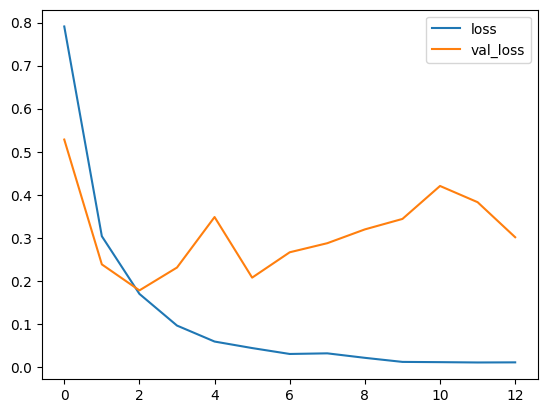

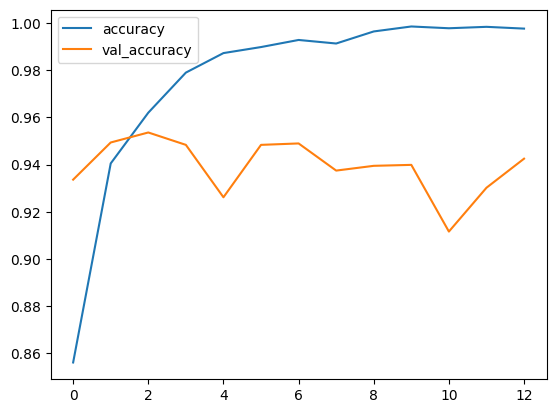

In [20]:
# Graph: loss and accuracy epoch-by-epoch
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()

In [21]:
# Table: loss and accuracy epoch-by-epoch
history_df

,loss,accuracy,val_loss,val_accuracy,lr
0,0.790948,0.856134,0.528254,0.933602,0.0010
1,0.303673,0.940469,0.238226,0.949344,0.0010
2,0.169690,0.961966,0.177807,0.953582,0.0010
3,0.096097,0.978954,0.230932,0.948335,0.0010
4,0.058983,0.987222,0.348232,0.926135,0.0010
5,0.043837,0.989778,0.207470,0.948335,0.0010
6,0.030121,0.992784,0.266365,0.948940,0.0010
7,0.031568,0.991281,0.287466,0.937437,0.0010
8,0.021146,0.996392,0.319542,0.939455,0.0005
9,0.011694,0.998497,0.343844,0.939859,0.0005


(b) Obtain model evaluation metrics

In [22]:
# Define function: generate predicted classes as a numpy array

def pred_class(pred_prob_varname):
    pred_class_all = (pred_prob_varname >= 0.5).astype(int)
    return pred_class_all

In [23]:
# Obtain predicted probabilities and classes
y_train_pred_prob  = model.predict(X_train_bal_seq_padded)
y_train_pred_class = pred_class(y_train_pred_prob)

y_test_pred_prob  = model.predict(X_test_seq_padded)
y_test_pred_class = pred_class(y_test_pred_prob)

155/155 [==============================] - 13s 12ms/step


In [24]:
# Print model evaluation metrics: "training" data
print("== Classification Report: Training Data ==", "\n")
print(classification_report(y_train_bal, y_train_pred_class))

== Classification Report: Training Data == 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3326
           1       0.99      0.99      0.99      3326

    accuracy                           0.99      6652
   macro avg       0.99      0.99      0.99      6652
weighted avg       0.99      0.99      0.99      6652



In [25]:
# Print model evaluation metrics: "testing" data
print("== Classification Report: Testing Data ==", "\n")
print(classification_report(y_test, y_test_pred_class))

== Classification Report: Testing Data == 

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       832
           1       0.98      0.96      0.97      4123

    accuracy                           0.95      4955
   macro avg       0.90      0.94      0.92      4955
weighted avg       0.96      0.95      0.95      4955



<b>Comments</b>

Performance on: "Training" Data
* The model performs well across all evaluation metrics and across all classes, with (a) precision, (b) recall, (c) f1-score and (d) overall accuracy being > 0.90 

Performance on: "Testing" Data
* The model performs well across all evaluation metrics and across all classes, with (a) precision, (b) recall, (c) f1-score and (d) overall accuracy being > 0.85 


---

<b>6. Comparison of Model Performance - Multinomial vs. Binomial Classifier: w GloVe-based Word Vectoriser</b>

(a) Evaluation Metrics of Interest

* Accuracy: % of predictions that are correct 

* F1-Score: Composite measure that considers both (i) “precision” and (ii) “recall”

    * “precision”: % of predicted “positives” that are true
        * Relevant as a low precision score on detecting hate speech indicates that we are wrongly censoring non-hate speech that could be of interest to readers

    * “recall”: % of actual “positives” that are predicted correctly
        * Relevant as we wish to identify as high a proportion of hate speech that exists
<br>

(b-1) Training Data

|Multinomial|F1-Score|Accuracy|Support|
|---|---|---|---|
|Class 0: Hate|0.97|---|3429|
|Class 1: Offensive|0.96|---|3350|
|Class 2: Neither|0.99|---|3326|
|Overall|---|0.97|10105|

<br>

|Binary|F1-Score|Accuracy|Support|
|---|---|---|---|
|Class 0: Neither|0.98|---|3326|
|Class 1: Hateful + Offensive|0.98|---|3326|
|Overall|---|0.98|6652|

<br>

(b-2) Testing Data

|Multinomial|F1-Score|Accuracy|Support|
|---|---|---|---|
|Class 0: Hate|0.40|---|285|
|Class 1: Offensive|0.91|---|3838|
|Class 2: Neither|0.82|---|832|
|Overall|---|0.86|4955|

<br>

|Binary|F1-Score|Accuracy|Support|
|---|---|---|---|
|Class 0: Neither|0.86|---|832|
|Class 1: Hateful + Offensive|0.97|---|4123|
|Overall|---|0.95|4955|

*note: scores may vary from code re-run to re-run*
<br>

---

<b>7. Key Insights</b>

Switching from a multiclass to binary classification approach allows us to circumvent difficulties with separately identifying hate speech, whilst being able to identify hurtful speech (hate speech & offensive language) well - considering the high “accuracy” and “F1” “test” scores and their small gap with “training” scores. 


---

<b> 8. Export Fitted Model's Components as Pickle Files </b>

In [26]:
# Export Fitted Tokeniser and Model
joblib.dump(tokenizer,"pickle_files/Model_02B_tokenizer.pkl")
joblib.dump(model,"pickle_files/Model_02B_model.pkl")

['pickle_files/Model_02b2_model']